Seq2Seq with PyTorch
====


Simple RNN Encoder-Decoder network.


### `pip` requirements: 

```
gensim>=3.7.0
torch>=1.0.0
nltk>=3.4.0
tqdm
```


In [1]:
# IPython candies...
from IPython.display import Image
from IPython.core.display import HTML 

In [2]:
# Imports we need.
import random
import pickle

import numpy as np
from tqdm import tqdm

from gensim.corpora import Dictionary

import torch
from torch import nn, optim, tensor, autograd
from torch.autograd import Variable
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

device = 'cuda' if torch.cuda.is_available else 'cpu'

In [3]:
try: # Use the default NLTK tokenizer.
    from nltk import word_tokenize, sent_tokenize 
    # Testing whether it works. 
    # Sometimes it doesn't work on some machines because of setup issues.
    word_tokenize(sent_tokenize("This is a foobar sentence. Yes it is.")[0])
except: # Use a naive sentence tokenizer and toktok.
    import re
    from nltk.tokenize import ToktokTokenizer
    # See https://stackoverflow.com/a/25736515/610569
    sent_tokenize = lambda x: re.split(r'(?<=[^A-Z].[.?]) +(?=[A-Z])', x)
    # Use the toktok tokenizer that requires no dependencies.
    toktok = ToktokTokenizer()
    word_tokenize = word_tokenize = toktok.tokenize

Kopi Problems
====

In this hands-on session, we want to **train an neural network to translate from Singlish Kopi orders to English.**


**"Singlish" -> English**

```
"Kopi" -> Coffee with condensed milk
"Kopi O" -> Coffee without milk or sugar
"Kopi dinosaur gau siew dai peng" -> ???
```

(Image Source: http://www.straitstimes.com/lifestyle/food/get-your-kopi-kick)

In [4]:
Image(url="https://static.straitstimes.com.sg/sites/default/files/160522_kopi.jpg", width=500)

Seriously?
----

Yes, we'll be translating Singlish Kopi orders to English using the [sequence-to-sequence network](https://arxiv.org/abs/1409.3215) (Sutskever et al. 2014).

But first...
---

# Data Munging


Before any machine/deep learning, we have to get some data and "hammer" it until we get it into the shape we want.

> *Data scientists spend 60% of their time on cleaning and organizing data. Collecting data sets comes second at 19% of their time, meaning data scientists spend around 80% of their time on preparing and managing data for analysis.*

> (Source: [Gil Press](https://www.forbes.com/sites/gilpress/2016/03/23/data-preparation-most-time-consuming-least-enjoyable-data-science-task-survey-says/#3e4dc0416f63) Forbes article)

**Step 1:** Take the data from somewhere, in this case: http://kaggle.com/alvations/sg-kopi.

**Step 2:** Import your favorite dataframe and text processing library.

**Step 3:** Munge the data till desired.

In [5]:
import pandas as pd
from gensim.corpora.dictionary import Dictionary
from nltk import word_tokenize

# Reads the tab-delimited data using Pandas.
kopitiam = pd.read_csv('kopitiam.csv', sep=',')
kopitiam.head()

,Singlish,English,Source
0,Kopi O,Black Coffee with Sugar,https://daneshd.com/2010/02/28/a-rough-guide-t...
1,Kopi,Black Coffee with Condensed Milk,https://daneshd.com/2010/02/28/a-rough-guide-t...
2,Kopi C,Black Coffee with Evaporated Milk,https://daneshd.com/2010/02/28/a-rough-guide-t...
3,Kopi Kosong,Black Coffee without sugar or milk,https://daneshd.com/2010/02/28/a-rough-guide-t...
4,Kopi Gah Dai,Black Coffee with extra condensed milk,https://daneshd.com/2010/02/28/a-rough-guide-t...


# Reshaping the Data and Adding START and END Symbols

To get the data in shape, we want to:
  
  1. normalize and tokenize of the input
  2. pad the input with START (`<s>`) and END (`</s>`) symbols.

If we look at the data carefully, sometimes we see that we have a mix of capitalized and lowered cased spellings, esp. in the "Local Terms" column. E.g. "Kopi O" and "Kopi o". For simplicity, we'll lowercase all the inputs and outputs so that our models don't think that the big "O" and the small "o" are different things.

Additionally, we want to tokinze our input so that we pad the punctuations with spaces away from the preceeding or following word. There are many tokenization functions, we'll use the `word_tokenize()` function in `nltk`.

As for padding the sentence with START and END symbols. It's an indication that we give to our Recurrent Neural Network (RNN) that denotes the start/end of our in/output sequences. 


(**Cut-away:** Here's some experts pitching in on why we need the START/END symbol. https://twitter.com/alvations/status/955770616648364037) 

In [6]:
# Use a unique string to indicate START and END of a sentence.
# Assign a unique index to them.
START, START_IDX = '<s>',  0
END, END_IDX = '</s>', 1

# We use this idiom to tokenize our sentences in the dataframe column:
# >>> DataFrame['column'].apply(str.lower).apply(word_tokenize)

# Also we added the START and the END symbol to the sentences. 
singlish_sents = [START] + kopitiam['Singlish'].apply(str.lower).apply(word_tokenize) + [END]
english_sents = [START] + kopitiam['English'].apply(str.lower).apply(word_tokenize) + [END]


In [7]:
# We're sort of getting into the data into the shape we want. 
# But now it's still too humanly readable and redundant.
## Cut-away: Computers like it to be simpler, more concise. -_-|||
print('First Singlish sentence:\t', singlish_sents[0])
print('First English sentence:\t\t', english_sents[0])

First Singlish sentence:	 ['<s>', 'kopi', 'o', '</s>']
First English sentence:		 ['<s>', 'black', 'coffee', 'with', 'sugar', '</s>']


# Create the PyTorch Dataset 

In [8]:
class KopitiamDataset(Dataset):
    def __init__(self, src_sents, trg_sents, max_len=-1):
        assert len(src_sents) == len(trg_sents), "There should be the same no. of sentence for both source and target."
        self.src_sents = src_sents
        self.trg_sents = trg_sents

        # Create the vocabulary for both the source and target.
        self.src_vocab = Dictionary(src_sents)
        self.trg_vocab = Dictionary(trg_sents)
        
        # Patch the vocabularies and add the <pad> and <unk> symbols.
        special_tokens = {'<pad>': 0, '<unk>':1, '<s>':2, '</s>':3}
        self.src_vocab.patch_with_special_tokens(special_tokens)
        self.trg_vocab.patch_with_special_tokens(special_tokens)
        
        # Keep track of how many data points.
        self._len = len(src_sents)
        
        if max_len < 0:
            # If it's not set, find the longest text in the data.
            max_src_len = max(len(sent) for sent in src_sents)
            max_trg_len = max(len(sent) for sent in trg_sents)
            self.max_len = max(max_src_len, max_trg_len)
        else:
            self.max_len = max_len
        
    def pad_sequence(self, vectorized_sent, max_len):
        # To pad the sentence:
        # Pad left = 0; Pad right = max_len - len of sent.
        pad_dim = (0, max_len - len(vectorized_sent))
        return F.pad(vectorized_sent, pad_dim, 'constant')
        
    def __getitem__(self, index):
        vectorized_src = self.vectorize(self.src_vocab, self.src_sents[index])
        vectorized_trg = self.vectorize(self.trg_vocab, self.trg_sents[index])
        
        return {'x':self.pad_sequence(vectorized_src, self.max_len), 
                'y':self.pad_sequence(vectorized_trg, self.max_len), 
                'x_len':len(vectorized_src), 
                'y_len':len(vectorized_trg)}
    
    def __len__(self):
        return self._len
    
    def vectorize(self, vocab, tokens):
        """
        :param tokens: Tokens that should be vectorized. 
        :type tokens: list(str)
        """
        # See https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.doc2idx 
        # Lets just cast list of indices into torch tensors directly =)
        return torch.tensor(vocab.doc2idx(tokens))
    
    def unvectorize(self, vocab, indices):
        """
        :param indices: Converts the indices back to tokens.
        :type tokens: list(int)
        """
        return [vocab[i] for i in indices]

In [9]:
kopi_data = KopitiamDataset(singlish_sents, english_sents)

In [10]:
batch_size = 3
dataloader = DataLoader(dataset=kopi_data, 
                        batch_size=batch_size, 
                        shuffle=True)

def sort_batch_by_len(data_dict):
    # Sort indices of data in batch by lengths.
    sorted_indices = np.array(data_dict['x_len']).argsort()[::-1].tolist()
    data_batch = {name:_tensor[sorted_indices]
                  for name, _tensor in data_dict.items()}
    return data_batch

for data_dict in dataloader:
    data_batch = sort_batch_by_len(data_dict)
    print(data_batch)
    break

{'x': tensor([[ 2, 68, 10, 11,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0],
        [ 2, 13, 14,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0],
        [ 2, 13,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0]]), 'y': tensor([[  2,  21,  22, 116,   5,   6,   7,   3,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0],
        [  2,  74,  92,  29, 115, 114,   3,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0],
        [  2,  24,  29,   5,   6,   7,  23,   4,   3,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0]]), 'x_len': tensor([5, 4, 3]), 'y_len': tensor([8, 7, 9])}


# RNN Matrix Manipulation Magic

Normally for a feed-forward network, we pad our variable length inputs so that the matrix operations can be done in the usual manner with fixed length matrices.

### !! All the variables start with 2 and end with 3 (start and stop symbol for RNN) !!

In [11]:
# For example, we have tensors with variable lengths.
t1 = torch.tensor([2, 13, 5, 8, 3]).float()
t2 = torch.tensor([2, 10, 3]).float()
t3 = torch.tensor([2, 10, 1, 3]).float()

In [12]:
# If the dimensions are different, you can't even stack them into a matrix.
torch.stack([t1, t2, t3])

RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 0. Got 5 and 3 in dimension 1 at /Users/soumith/mc3build/conda-bld/pytorch_1549597882250/work/aten/src/TH/generic/THTensorMoreMath.cpp:1307

# Gotcha! You have to pad the tensors before stacking

In [13]:
# So we have to pad them, e.g. 
_max_len = max(len(t1), len(t2), len(t3))

t1 = F.pad(t1, (0, _max_len-len(t1)), 'constant')
t2 = F.pad(t2, (0, _max_len-len(t2)), 'constant')
t3 = F.pad(t3, (0, _max_len-len(t3)), 'constant')

torch.stack([t1, t2, t3])

tensor([[ 2., 13.,  5.,  8.,  3.],
        [ 2., 10.,  3.,  0.,  0.],
        [ 2., 10.,  1.,  3.,  0.]])

In PyTorch, there's a way to handle the variable length when we try to send mini-batches of tensors to the layers (i.e. `nn.Module` objects).

To do so, we use the `PackedSequence` object. We can use the `torch.nn.utils.rnn.pack_padded_sequence` function, to create the `PackedSequence` object from a normal fixed size matrix with padded zeros.

Lets see how it works.

In [14]:
batch_size = 3
dataloader = DataLoader(dataset=kopi_data, batch_size=batch_size, 
                        shuffle=False)

# Hack to make dataloader give us the first batch.
data_batch = next(iter(dataloader)) 

data_batch['x']

tensor([[ 2, 68, 67,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0],
        [ 2, 68,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0],
        [ 2, 68,  4,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0]])

In [15]:
data_batch['x_len']

tensor([4, 3, 4])

In [16]:
packed_tensor = pack_padded_sequence(data_batch['x'],
                                     data_batch['x_len'], 
                                     batch_first=True)
packed_tensor

RuntimeError: 'lengths' array has to be sorted in decreasing order

# Gotcha! There's a caveat to `pack_padded_sequence`

The batch of tensors that you send to `pack_padded_sequence` needs to be sorted in descreasing length first. Ah ha! Now we know why we were always sorting the batches when we use the dataloader =)

In [17]:
batch_size = 3
dataloader = DataLoader(dataset=kopi_data, batch_size=batch_size, shuffle=True)

def sort_batch_by_len(data_batch):
    # Sort indices of data in batch by lengths.
    sorted_indices = np.array(data_dict['x_len']).argsort()[::-1].tolist()
    data_batch = {name:_tensor[sorted_indices]
                  for name, _tensor in data_dict.items()}
    return data_batch


# Hack to make dataloader give us the first batch.
data_batch = next(iter(dataloader)) 

# Apply the `pack_padded_sequence` to the batch.
data_batch = sort_batch_by_len(data_batch)
packed_tensor = pack_padded_sequence(data_batch['x'], data_batch['x_len'], batch_first=True)
packed_tensor

PackedSequence(data=tensor([ 2,  2,  2, 68, 13, 13, 10, 14,  3, 11,  3,  3]), batch_sizes=tensor([3, 3, 3, 2, 1]))

## [Optional]: Sorting tensor by value

Here's some cut-away tensor kungfu (i.e. tensor-fu) to understand how we got the `sorted_indices`.

In [18]:
_padded_x_tensors = tensor(
    [[ 2, 13,  6,  3,  0,  0,  0,  0,  0],
     [ 2, 68,  3,  0,  0,  0,  0,  0,  0],
     [ 2, 68, 67,  5,  3,  0,  0,  0,  0]
    ])

_tensor_lens = [4, 3, 5]

In [19]:
# First, to perform any operations within the tensors, 
# it's easiest to cast them into numpy arrays
np.array(_tensor_lens)

array([4, 3, 5])

In [20]:
# Using the `.argsort()` function in the numpy array
# would return an array of the indices sorted by their
# values in ascending order.
np.array(_tensor_lens).argsort()

array([1, 0, 2])

In [21]:
# But for the `pack_padded_sequence`, we want our 
# tensor lengths to be sorted in a descending order, 
# so we do a reverse.

# Normally you can use the native python `reversed()` 
# function and the idiom looks as below, but that will
# lose the np.array object
list(reversed(np.array(_tensor_lens).argsort()))

[2, 0, 1]

In [22]:
# To keep the np.array object, 
# we can use the [::-1] slice notion to reverse the array.
# See https://stackoverflow.com/a/31633656/610569 
np.array(_tensor_lens).argsort()[::-1]

array([2, 0, 1])

In [23]:
# However, keeping the array as a numpy object can't 
# be used to change the order of the _padded_x_tensors
# so we still have to cast it to a list to reorder 
# the _padded_x_tensors by descending length

In [24]:
# Sort the indices by descending order.
sorted_indices = np.array(_tensor_lens).argsort()[::-1].tolist()
# Use the slice notation on the tensor to reorder the tensor.
print(_tensor_lens)
print(_padded_x_tensors)
print()
print(sorted(_tensor_lens, reverse=True))
print(_padded_x_tensors[sorted_indices])

[4, 3, 5]
tensor([[ 2, 13,  6,  3,  0,  0,  0,  0,  0],
        [ 2, 68,  3,  0,  0,  0,  0,  0,  0],
        [ 2, 68, 67,  5,  3,  0,  0,  0,  0]])

[5, 4, 3]
tensor([[ 2, 68, 67,  5,  3,  0,  0,  0,  0],
        [ 2, 13,  6,  3,  0,  0,  0,  0,  0],
        [ 2, 68,  3,  0,  0,  0,  0,  0,  0]])


# Undoing the PackedSequence

If for some reason you'll need to undo the packing for the `PackedSeqeunce` object, you can use the `pad_packed_sequence` function, e.g. 

In [25]:
# If you didn't specify the batch_first argument, you see that our tensors got transposed.
pad_packed_sequence(packed_tensor, batch_first=False)

(tensor([[ 2,  2,  2],
         [68, 13, 13],
         [10, 14,  3],
         [11,  3,  0],
         [ 3,  0,  0]]), tensor([5, 4, 3]))

In [26]:
# To get back the original tensor before packing, we set batch_first=True.
unpacked_tensor, unpacked_tensor_len = pad_packed_sequence(packed_tensor, batch_first=True)
unpacked_tensor

tensor([[ 2, 68, 10, 11,  3],
        [ 2, 13, 14,  3,  0],
        [ 2, 13,  3,  0,  0]])

In [27]:
unpacked_tensor_len

tensor([5, 4, 3])

# The Seq2Seq Model


A Recurrent Neural Network (RNN), is a network that operates on a sequence and uses its own output as input for subsequent steps.

> *The general idea is to make **two recurrent neural network transform from one sequence to another**. An encoder network condenses an input sequence into a vector and a decoder netwrok unfolds the vector into a new sequence.*



# The Encoder

The encoder of a seq2seq network is a RNN that outputs some value for every word from the input sentence. For every input word the encoder outputs a vector and a hidden state, and uses the hidden state for the next input word.


<img src="http://pytorch.org/tutorials/_images/encoder-network.png" align='left'>

In [28]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        # Set the no. of nodes for the hidden layer.
        self.hidden_size = hidden_size
        # Initialize the embedding layer with the 
        # - size of input (i.e. no. of words in input vocab)
        # - no. of hidden nodes in the embedding layer
        self.embedding = nn.Embedding(input_size, hidden_size,
                                      padding_idx=0)
        # Initialize the GRU with the 
        # - size of the hidden layer from the previous state
        # - size of the hidden layer from the current state
        self.gru = nn.GRU(hidden_size, hidden_size)

 
    def forward(self, inputs, inputs_lengths):
        # Feed the input into the embedding layer.
        embedded = self.embedding(inputs)
        # Create PackedSequence
        lengths = inputs_lengths.detach().cpu().numpy()
        embedded_packed = pack_padded_sequence(embedded, lengths, 
                                               batch_first=True)
        # Feed the embedded layer with the hidden layer to the GRU.
        # Update the output and hidden layer.
        output, hidden = self.gru(embedded_packed)
        return output, hidden
        

# Simple Decoder

In the simplest seq2seq decoder we use only last output of the encoder. This last output is sometimes called the context vector as it encodes context from the entire sequence. This context vector is used as the initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and hidden state. The initial input token is the start-of-string `<s>` token, and the first hidden state is the context vector (the encoder’s last hidden state).


<img src="http://pytorch.org/tutorials/_images/decoder-network.png" align='left'>


In [29]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        # Set the no. of nodes for the hidden layer.
        self.hidden_size = hidden_size
        # Initialize the embedding layer with the 
        # - size of output (i.e. no. of words in output vocab)
        # - no. of hidden nodes in the embedding layer
        self.embedding = nn.Embedding(output_size, hidden_size,
                                     padding_idx=0)
        # Initialize the GRU with the 
        # - size of the hidden layer from the previous state
        # - size of the hidden layer from the current state
        self.gru = nn.GRU(hidden_size, hidden_size)
        # Initialize the "classifier" linear layer.
        self.out = nn.Linear(hidden_size, output_size)
        # Set the output layer to output a specific symbol 
        # from the output vocabulary
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        # Get the embedding of the current input word (last output word)
        batch_size = input.size(0)
        embedded = self.embedding(input)
        embedded = embedded.permute(1, 0, 2) # S=1 x B x N
        # Transform the embedded output with a relu function. 
        output = F.relu(embedded)
        # Get current hidden state from input word and last hidden state
        output, hidden = self.gru(output, hidden)
        # Take the updated output and find the most appropriate
        # output symbol. 
        output = self.softmax(self.out(output).squeeze(0))
        return output, hidden


# Walking through the tensors 

Before we move on with the training data, we should take a look at the coolest feature of PyTorch (aka Tensorflow Eager mode way before eager mode is a thing). 

The fact that we can hijack the training process and start printing out layer output values or current parameters without needing to wait till the end of the training is pretty powerful. 

This is an artifact of how the PyTorch library designer allows users to probe and change the network at any point of time without first declaring and fixing a specific network. 

**Cut-away:** Here's some heated blogpost of imperative/declarative programming style.

- Funny yet Informative: https://tylermcginnis.com/imperative-vs-declarative-programming/

- Simple Python is de facto imperative but it's possible to do otherwise: http://www.benfrederickson.com/python-as-a-declarative-programming-language/

<!--
Pardon me being frank (not hotdog)
----

IMHO, I (Liling) don't really care how I write my network as long as the library allows me to have flexibility to alter networks and training mechanisms to suit what I'm trying to do. And for now, I write less code to do the same thing in PyTorch, so yeah... -->

----

Lets start from feeding a batch to an encoder...

In [30]:
# Initialize the data.
batch_size = 3
kopi_data = KopitiamDataset(singlish_sents, english_sents)
dataloader = DataLoader(dataset=kopi_data, batch_size=batch_size, shuffle=True)

# Initialize the network for encoder and decoder.
hidden_size = 7
_encoder = EncoderRNN(len(kopi_data.src_vocab), hidden_size)
_decoder = DecoderRNN(hidden_size, len(kopi_data.trg_vocab))

In [31]:
_data_batch = sort_batch_by_len(next(iter(dataloader)))

In [32]:
_data_batch['x'], _data_batch['x_len']

(tensor([[ 2, 68, 10, 11,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0],
         [ 2, 13, 14,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0],
         [ 2, 13,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0]]), tensor([5, 4, 3]))

In [33]:
# The input is of shape:
# batch_size * max_len
_data_batch['x'].shape

torch.Size([3, 19])

In [34]:
_encoder(_data_batch['x'], _data_batch['x_len'])

(PackedSequence(data=tensor([[-0.4365,  0.0405,  0.8090,  0.2884, -0.4206,  0.5598,  0.1304],
         [-0.4365,  0.0405,  0.8090,  0.2884, -0.4206,  0.5598,  0.1304],
         [-0.4365,  0.0405,  0.8090,  0.2884, -0.4206,  0.5598,  0.1304],
         [-0.4013, -0.2246,  0.7697,  0.4100, -0.2742, -0.2106,  0.2832],
         [ 0.1244,  0.1659,  0.8027,  0.5737, -0.0861,  0.2937,  0.2082],
         [ 0.1244,  0.1659,  0.8027,  0.5737, -0.0861,  0.2937,  0.2082],
         [-0.4328,  0.2636,  0.4947,  0.3177,  0.1898, -0.0414,  0.3013],
         [ 0.1832,  0.0478,  0.7031,  0.4738, -0.2603,  0.2286,  0.3365],
         [-0.4585,  0.1465,  0.7847,  0.2961, -0.3765,  0.1915,  0.2410],
         [ 0.4353, -0.0459, -0.2597,  0.0734, -0.1335, -0.2561,  0.4762],
         [-0.4229,  0.0814,  0.7481,  0.2363, -0.4675,  0.1786,  0.3419],
         [-0.2900,  0.1559,  0.3424,  0.0213, -0.3576,  0.0399,  0.4032]],
        grad_fn=<CatBackward>), batch_sizes=tensor([3, 3, 3, 2, 1])),
 tensor([[[-0.2900,  

In [35]:
_encoder(_data_batch['x'], _data_batch['x_len'])[0]

PackedSequence(data=tensor([[-0.4365,  0.0405,  0.8090,  0.2884, -0.4206,  0.5598,  0.1304],
        [-0.4365,  0.0405,  0.8090,  0.2884, -0.4206,  0.5598,  0.1304],
        [-0.4365,  0.0405,  0.8090,  0.2884, -0.4206,  0.5598,  0.1304],
        [-0.4013, -0.2246,  0.7697,  0.4100, -0.2742, -0.2106,  0.2832],
        [ 0.1244,  0.1659,  0.8027,  0.5737, -0.0861,  0.2937,  0.2082],
        [ 0.1244,  0.1659,  0.8027,  0.5737, -0.0861,  0.2937,  0.2082],
        [-0.4328,  0.2636,  0.4947,  0.3177,  0.1898, -0.0414,  0.3013],
        [ 0.1832,  0.0478,  0.7031,  0.4738, -0.2603,  0.2286,  0.3365],
        [-0.4585,  0.1465,  0.7847,  0.2961, -0.3765,  0.1915,  0.2410],
        [ 0.4353, -0.0459, -0.2597,  0.0734, -0.1335, -0.2561,  0.4762],
        [-0.4229,  0.0814,  0.7481,  0.2363, -0.4675,  0.1786,  0.3419],
        [-0.2900,  0.1559,  0.3424,  0.0213, -0.3576,  0.0399,  0.4032]],
       grad_fn=<CatBackward>), batch_sizes=tensor([3, 3, 3, 2, 1]))

In [36]:
# The sum of all tensors' lengths varies in every batch
print(sum(_encoder(_data_batch['x'], _data_batch['x_len'])[0].batch_sizes))

# The hidden dimension of the encoder. 
print(_encoder.hidden_size)

# The output size of the tensor in the PackedSequence is
# sum of tensors' lengths* hidden_dim
print(_encoder(_data_batch['x'], _data_batch['x_len'])[0].data.shape)

tensor(12)
7
torch.Size([12, 7])


In [37]:
# Put the batch into encoder.
_packed_encoder_output, _encoder_hidden = _encoder(_data_batch['x'], _data_batch['x_len'])

# Unpack the PackedSequence.
_encoder_output, _encoder_input_lens = pad_packed_sequence(_packed_encoder_output, 
                                                           batch_first=True)

In [38]:
_packed_encoder_output

PackedSequence(data=tensor([[-0.4365,  0.0405,  0.8090,  0.2884, -0.4206,  0.5598,  0.1304],
        [-0.4365,  0.0405,  0.8090,  0.2884, -0.4206,  0.5598,  0.1304],
        [-0.4365,  0.0405,  0.8090,  0.2884, -0.4206,  0.5598,  0.1304],
        [-0.4013, -0.2246,  0.7697,  0.4100, -0.2742, -0.2106,  0.2832],
        [ 0.1244,  0.1659,  0.8027,  0.5737, -0.0861,  0.2937,  0.2082],
        [ 0.1244,  0.1659,  0.8027,  0.5737, -0.0861,  0.2937,  0.2082],
        [-0.4328,  0.2636,  0.4947,  0.3177,  0.1898, -0.0414,  0.3013],
        [ 0.1832,  0.0478,  0.7031,  0.4738, -0.2603,  0.2286,  0.3365],
        [-0.4585,  0.1465,  0.7847,  0.2961, -0.3765,  0.1915,  0.2410],
        [ 0.4353, -0.0459, -0.2597,  0.0734, -0.1335, -0.2561,  0.4762],
        [-0.4229,  0.0814,  0.7481,  0.2363, -0.4675,  0.1786,  0.3419],
        [-0.2900,  0.1559,  0.3424,  0.0213, -0.3576,  0.0399,  0.4032]],
       grad_fn=<CatBackward>), batch_sizes=tensor([3, 3, 3, 2, 1]))

In [39]:
_encoder_hidden.squeeze(0).squeeze(0).squeeze(0).shape

torch.Size([3, 7])

In [40]:
# Initialize the decoder to start with the <s> symbol.
decoder_input = kopi_data.vectorize(kopi_data.trg_vocab, ['<s>'])
# Create no. of batches * the initial_state.
first_state = torch.stack([_decoder.embedding(decoder_input)] * batch_size).permute(1, 0, 2)

# Put the first state and the output of the encoder into the 
# GRU layer of the decoder.
_decoder_out, _decoder_hidden = _decoder.gru(first_state, _encoder_hidden)

In [41]:
_decoder_out, _decoder_hidden

(tensor([[[-0.6609,  0.3348, -0.0317, -0.0727,  0.0593,  0.2016, -0.1152],
          [-0.6783,  0.2977,  0.1865,  0.0786,  0.0873,  0.2576, -0.1324],
          [-0.6877,  0.3536,  0.2014,  0.1250,  0.1201,  0.2556, -0.1895]]],
        grad_fn=<StackBackward>),
 tensor([[[-0.6609,  0.3348, -0.0317, -0.0727,  0.0593,  0.2016, -0.1152],
          [-0.6783,  0.2977,  0.1865,  0.0786,  0.0873,  0.2576, -0.1324],
          [-0.6877,  0.3536,  0.2014,  0.1250,  0.1201,  0.2556, -0.1895]]],
        grad_fn=<StackBackward>))

In [42]:
F.softmax(_decoder.out(_decoder_out).squeeze(0)).shape

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


torch.Size([3, 118])

In [49]:
len(kopi_data.trg_vocab.values())

118

In [44]:
idx = int(torch.max(F.softmax(_decoder.out(_decoder_out).squeeze(0), dim=1), 1)[1][0])
kopi_data.trg_vocab[idx]

'topping'

In [45]:
decoder_input = kopi_data.vectorize(kopi_data.trg_vocab, ['<s>'])
_decoder.embedding(torch.stack([decoder_input] * batch_size)).permute(1, 0, 2)

tensor([[[-0.6696,  0.5149, -0.6238,  1.4911, -1.9001,  0.5816, -1.4319],
         [-0.6696,  0.5149, -0.6238,  1.4911, -1.9001,  0.5816, -1.4319],
         [-0.6696,  0.5149, -0.6238,  1.4911, -1.9001,  0.5816, -1.4319]]],
       grad_fn=<PermuteBackward>)

In [46]:
# To sum up the above, if we have a batch,
# first put it into the encoder:
_data_batch['x'], _data_batch['x_len']
_packed_encoder_output, _encoder_hidden = _encoder(_data_batch['x'], _data_batch['x_len'])

# Then create the initial state for the decoder.
batch_size = _encoder_hidden.size(1) # Assumes `batch_first=True`
decoder_input = kopi_data.vectorize(kopi_data.trg_vocab, ['<s>'])
first_state = torch.stack([decoder_input] * batch_size)

# Put the first state and the output of the encoder into the 
# GRU layer of the decoder.
_decoder_out, _decoder_hidden = _decoder(first_state, _encoder_hidden)

In [47]:
# Finally to get the predictions.
torch.max(_decoder_out.squeeze(0), 1)

(tensor([-4.2356, -4.2476, -4.2566], grad_fn=<MaxBackward0>),
 tensor([37, 37, 37]))

#  Training the Model

To train we run the input sentence through the encoder, and keep track of every output and the latest hidden state. Then the decoder is given the `<s>` token as its first input, and the last hidden state of the encoder as its first hidden state.


As with all gradient methods in deep/machine learning, the basic idea is to:

 1.	Initialize the models and hyperparameters
 2.	Iterate through the data points (Xs and Ys)
 3.	Clear the gradient outputs
 4.	Forward propagate, i.e. apply the model to the inputs to generate the predictions
 5.	Compute the loss for the predictions against the truth value
 6.	Backpropagate, i.e. compute the partial gradients 
 7.	Optimizers update the model parameters

 
**Note:** If you're unfamiliar with the steps above, I strongly encourage you to:

 - Watch @sirajraval on https://www.youtube.com/embed/q555kfIFUCM and 
 - Spend some time going through this blogpost by @iamtrask http://iamtrask.github.io/2015/07/12/basic-python-network/



### Teacher Forcing
Teacher forcing is a method for quickly and efficiently training recurrent neural network models that use the output from a prior time step as input.

It is a network training method critical to the development of deep learning language models used in machine translation, text summarization, and image captioning, among many other applications.

In [48]:
# 1. Initialize the models and hyperparameters
hidden_size = 1000
learning_rate=0.03
num_epochs = 100
criterion = nn.CrossEntropyLoss()
MAX_LENGTH=20
batch_size=5
teacher_forcing_ratio = 0.3

# Initialize the data.
kopi_data = KopitiamDataset(singlish_sents, english_sents)
dataloader = DataLoader(dataset=kopi_data, batch_size=batch_size, shuffle=True)

# Initialize the network for encoder and decoder.
encoder = EncoderRNN(len(kopi_data.src_vocab), hidden_size)
decoder = DecoderRNN(hidden_size, len(kopi_data.trg_vocab))

# Initialize the optimizer for encoder and decoder.
encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)



In [50]:
losses = []
for _e in range(num_epochs):
    # 2.Iterate through the data points (Xs and Ys)
    for data_dict in tqdm(dataloader):
        data_batch = sort_batch_by_len(data_dict)
        x, x_len = data_batch['x'], data_batch['x_len']
        y, y_len = data_batch['y'], data_batch['y_len']

        
        # 3. Clear the gradient outputs
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        
        packed_encoder_output, encoder_hidden = encoder(x, x_len)
        
        
        # Then create the initial state for the decoder.
        batch_size = encoder_hidden.size(1) # Assumes `batch_first=True`
        start_idx = kopi_data.vectorize(kopi_data.trg_vocab, ['<s>'])
        end_idx = kopi_data.vectorize(kopi_data.trg_vocab, ['</s>'])

        # Multiply the start_idx by batch_size no. of times.
        decoder_input = torch.stack([start_idx] * batch_size)
        # As the first state of the decoder, we take the last step of the encoder.
        decoder_hidden = encoder_hidden

        use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
        
        # Keeps track of the loss per batch.
        loss = 0
        
        # 4. Forward propagate
        # Iterate through each state in the decoder.
        # Note: when we are training we know the length of the decoder.
        #       so we can use the trick to restrict the loop when decoding.
        for di in range(max(y_len)):
            # We move forward through each state.
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            
            # Find the predicted words from the decoder_output
            top_scores, top_predictions = torch.max(decoder_output.squeeze(0), -1)
            decoder_input = y.transpose(0, 1)[di].view(batch_size, 1) if use_teacher_forcing else top_predictions.unsqueeze(1)
            ##decoder_input = top_predictions.unsqueeze(1)
            
            # 5. Compute the loss for the predictions against the truth value
            # Note: for cross entropy loss, the criterion expects
            # (i)  decoder output, float tensor, softmax probablities for all classes.
            # (ii) the long tensor of the target class.
            loss += criterion(decoder_output, y.transpose(0, 1)[di])
            
            # When all predictions are <pad>
            ##if decoder_input.sum() == 0:
            ##    break
        
        #decoder_input = kopi_data.pad_sequence(decoder_input, kopi_data.max_len)
            
        # 6. Backpropagate, i.e. compute the partial gradients 
        loss.backward()
        # Keep track of the current batch loss.
        losses.append(loss)
        # 7. Optimizers update the model parameters
        encoder_optimizer.step()
        decoder_optimizer.step()
    print(loss.data.item())

  0%|          | 0/34 [00:00<?, ?it/s]

41.31059265136719


  0%|          | 0/34 [00:00<?, ?it/s]

60.54841995239258


  0%|          | 0/34 [00:00<?, ?it/s]

17.384401321411133


  0%|          | 0/34 [00:00<?, ?it/s]

20.236000061035156


  0%|          | 0/34 [00:00<?, ?it/s]

9.43239688873291


  0%|          | 0/34 [00:00<?, ?it/s]

5.792956829071045


  0%|          | 0/34 [00:00<?, ?it/s]

18.849227905273438


  0%|          | 0/34 [00:00<?, ?it/s]

19.189157485961914


  0%|          | 0/34 [00:00<?, ?it/s]

9.14788818359375


  0%|          | 0/34 [00:00<?, ?it/s]

17.853139877319336


  0%|          | 0/34 [00:00<?, ?it/s]

17.06199073791504


  0%|          | 0/34 [00:00<?, ?it/s]

4.195402145385742


  0%|          | 0/34 [00:00<?, ?it/s]

12.504268646240234


  0%|          | 0/34 [00:00<?, ?it/s]

11.954922676086426


  0%|          | 0/34 [00:00<?, ?it/s]

20.549238204956055


  0%|          | 0/34 [00:00<?, ?it/s]

4.410516738891602


  0%|          | 0/34 [00:00<?, ?it/s]

15.9072847366333


  0%|          | 0/34 [00:00<?, ?it/s]

2.712801218032837


  0%|          | 0/34 [00:00<?, ?it/s]

24.26157569885254


  0%|          | 0/34 [00:00<?, ?it/s]

7.422495365142822


  0%|          | 0/34 [00:00<?, ?it/s]

3.553847551345825


  0%|          | 0/34 [00:00<?, ?it/s]

24.89777946472168


  0%|          | 0/34 [00:00<?, ?it/s]

6.088063716888428


  0%|          | 0/34 [00:00<?, ?it/s]

2.9115781784057617


  0%|          | 0/34 [00:00<?, ?it/s]

7.1534504890441895


  0%|          | 0/34 [00:00<?, ?it/s]

5.851185321807861


  0%|          | 0/34 [00:00<?, ?it/s]

5.324915885925293


  0%|          | 0/34 [00:00<?, ?it/s]

1.0603291988372803


  0%|          | 0/34 [00:00<?, ?it/s]

1.0293570756912231


  0%|          | 0/34 [00:00<?, ?it/s]

27.23015785217285


  0%|          | 0/34 [00:00<?, ?it/s]

19.049266815185547


  0%|          | 0/34 [00:00<?, ?it/s]

22.587512969970703


  0%|          | 0/34 [00:00<?, ?it/s]

13.749019622802734


  0%|          | 0/34 [00:00<?, ?it/s]

19.604101181030273


  0%|          | 0/34 [00:00<?, ?it/s]

10.611981391906738


  0%|          | 0/34 [00:00<?, ?it/s]

18.800962448120117


  0%|          | 0/34 [00:00<?, ?it/s]

1.8060235977172852


  0%|          | 0/34 [00:00<?, ?it/s]

16.0529727935791


  0%|          | 0/34 [00:00<?, ?it/s]

9.794147491455078


  0%|          | 0/34 [00:00<?, ?it/s]

10.160582542419434


  0%|          | 0/34 [00:00<?, ?it/s]

6.6376848220825195


  0%|          | 0/34 [00:00<?, ?it/s]

13.763915061950684


  0%|          | 0/34 [00:00<?, ?it/s]

3.3903098106384277


  0%|          | 0/34 [00:00<?, ?it/s]

8.150617599487305


  0%|          | 0/34 [00:00<?, ?it/s]

0.9800606966018677


  0%|          | 0/34 [00:00<?, ?it/s]

5.763169288635254


  0%|          | 0/34 [00:00<?, ?it/s]

11.74531364440918


  0%|          | 0/34 [00:00<?, ?it/s]

14.72944450378418


  0%|          | 0/34 [00:00<?, ?it/s]

8.258861541748047


  0%|          | 0/34 [00:00<?, ?it/s]

5.830611228942871


  0%|          | 0/34 [00:00<?, ?it/s]

7.462695598602295


  0%|          | 0/34 [00:00<?, ?it/s]

16.330860137939453


  0%|          | 0/34 [00:00<?, ?it/s]

3.8048932552337646


  0%|          | 0/34 [00:00<?, ?it/s]

4.696951389312744


  0%|          | 0/34 [00:00<?, ?it/s]

3.5801029205322266


  0%|          | 0/34 [00:00<?, ?it/s]

5.590264797210693


  0%|          | 0/34 [00:00<?, ?it/s]

12.872764587402344


  0%|          | 0/34 [00:00<?, ?it/s]

6.98143196105957


  0%|          | 0/34 [00:00<?, ?it/s]

0.724222719669342


  0%|          | 0/34 [00:00<?, ?it/s]

7.784213066101074


  0%|          | 0/34 [00:00<?, ?it/s]

0.40239495038986206


  3%|▎         | 1/34 [00:00<00:12,  2.57it/s]


KeyboardInterrupt: 

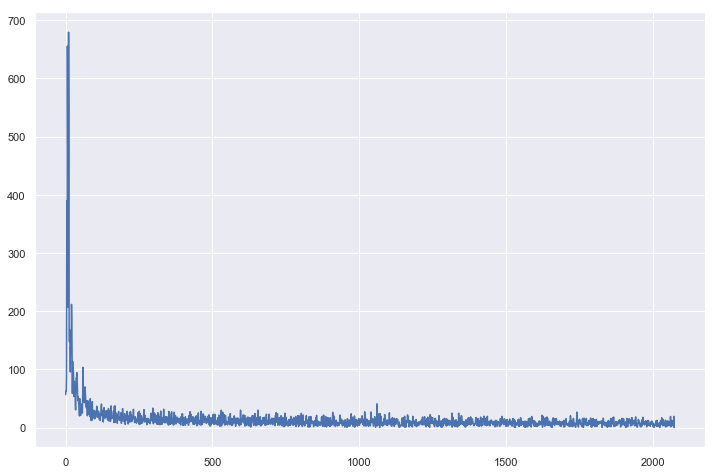

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(12, 8)})

plt.plot(losses)
plt.show()

# 2.3.6 Getting the Model to Translate

Remember that during training, our decode takes the `encoder_hidden` as in start state of the `decoder_hidden` and starts predicting the words as we move along the decoder states?

Similarly, when translating input sentences with no target sentences, we'll do the same prediction in the decoder but the only difference is that we **DON'T** need to:

- measure the difference between the prediction and the actual target sentence since we don't have it, (i.e. we don't need to do `criterion(decoder_output, y.transpose(0, 1)[di])`) and
- backpropagate nor update the loss
- do anything to the optimizer

In [53]:
packed_encoder_output, encoder_hidden 
encoder(x, x_len)

(PackedSequence(data=tensor([[-0.0565,  0.0557, -0.9634,  ..., -0.0144,  0.0474, -0.1354],
         [-0.0565,  0.0557, -0.9634,  ..., -0.0144,  0.0474, -0.1354],
         [-0.0565,  0.0557, -0.9634,  ..., -0.0144,  0.0474, -0.1354],
         ...,
         [ 0.4443, -0.1483, -0.8171,  ...,  0.9573,  0.3694, -0.9025],
         [ 0.2033, -0.4848,  0.9678,  ..., -0.9914, -0.8758, -0.8300],
         [ 0.4641, -0.1500, -0.8178,  ...,  0.9429,  0.3739, -0.8733]],
        grad_fn=<CatBackward>), batch_sizes=tensor([5, 5, 5, 5, 3, 2, 1])),
 tensor([[[ 0.4641, -0.1500, -0.8178,  ...,  0.9429,  0.3739, -0.8733],
          [ 0.2033, -0.4848,  0.9678,  ..., -0.9914, -0.8758, -0.8300],
          [ 0.2649, -0.2997, -0.9404,  ...,  0.0093, -0.4636, -0.2900],
          [-0.1935, -0.0763, -0.7118,  ...,  0.9007, -0.2745,  0.1660],
          [-0.2272,  0.2700, -0.4377,  ..., -0.5931,  0.4415,  0.0769]]],
        grad_fn=<StackBackward>))

In [54]:
x, x_len

(tensor([[ 2, 68,  4, 10,  8,  6,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0],
         [ 2, 68, 10,  5, 11,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0],
         [ 2, 13,  8,  6,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0],
         [ 2, 68,  9,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0],
         [ 2, 24, 25,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0]]), tensor([7, 6, 5, 4, 4]))

In [57]:
def translate(sent):
    sent_tensor = kopi_data.vectorize(kopi_data.src_vocab, sent)
    sent_len = len(sent_tensor)
    sent_tensor = kopi_data.pad_sequence(sent_tensor, kopi_data.max_len)

    # Encoder!!
    packed_encoder_output, encoder_hidden = encoder(sent_tensor.unsqueeze(0), tensor([sent_len]))

    start_idx = kopi_data.vectorize(kopi_data.trg_vocab, ['<s>'])
    # Multiply the start_idx by batch_size no. of times.
    decoder_input = torch.tensor([start_idx])
    decoder_hidden = encoder_hidden

    indices = []
    for di in range(kopi_data.max_len):
        # Create no. of batches * the initial_state.
        embedded = torch.stack([decoder.embedding(decoder_input)]).permute(1, 0, 2)
        decoder_out, decoder_hidden = decoder.gru(embedded, decoder_hidden)

        _, pred = torch.max(F.softmax(decoder.out(decoder_out).squeeze(0), dim=1), -1)
        decoder_input = pred
        indices.append(int(pred))

    translation = []
    for token in kopi_data.unvectorize(kopi_data.trg_vocab, indices):
        if token in ['</s>', '<pad>']:
            break
        if token == '<s>':
            continue
        translation.append(token)
    ##print(kopi_data.unvectorize(kopi_data.trg_vocab, indices))
    return ' '.join(translation)

In [64]:
sent = 'kopi peng'.split()
translate(sent)

'iced coffee ,'